In [1]:
!pip3 install wordcloud
!pip3 install pyLDAvis
!pip3 install emoji
import emoji
import numpy as np
import pandas as pd
import nltk
import pyLDAvis
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [2]:
file_path = '/Users/zhangshuting/Desktop/cleaned_gpt_reviews.csv'
df = pd.read_csv(file_path)

print("Data Overview:")
print(df.head())

Data Overview:
                               reviewId       userName  \
0  764bde06-e9d2-4211-97a2-f4f64bcf907d       M A saad   
1  36788635-5d48-4a4e-abdd-7fadffc07ac1   Sudip Sarkar   
2  74a2c5ec-2bdb-4784-ab8a-90224d65d981   Sehlule Moyo   
3  0f7a206b-4a5c-4b67-ad59-54e4d3cefe01  Preethi Preru   
4  e8f1438a-3734-4213-9884-aa33a9b79672   Fayzan Vhora   

                        comment  score            date_time  appVersion  \
0                   very active      5  2024-11-18 13:31:58  1.2024.310   
1               very nice app 🥰      5  2024-11-18 13:31:31  1.2024.268   
2                      good app      4  2024-11-18 13:31:05  1.2024.268   
3                     very good      5  2024-11-18 13:29:14  1.2024.310   
4  this is nice app for student      3  2024-11-18 13:27:53  1.2024.310   

         date      time Score_Sentiment  \
0  2024-11-18  13:31:58  Positive score   
1  2024-11-18  13:31:31  Positive score   
2  2024-11-18  13:31:05  Positive score   
3  2024-11-18

In [3]:
print("Available columns in the dataset:", df.columns)

if 'comment' in df.columns:
    df.rename(columns={"comment": "Review"}, inplace=True)
else:
    raise KeyError("'comment' column not found in the dataset.")

# Drop missing values in 'Review'
df = df.dropna(subset=['Review'])

Available columns in the dataset: Index(['reviewId', 'userName', 'comment', 'score', 'date_time', 'appVersion',
       'date', 'time', 'Score_Sentiment', 'tokens', 'cleaned_tokens',
       'Text_Sentiment', 'Emoji_Sentiment', 'Overall_Sentiment',
       'Comment_Sentiment'],
      dtype='object')


In [4]:
features = {
    'performance': ['performance','accurate', 'faster', 'freeze', 'slow', 'crash','loading','delay','smooth','easy','speed','responsive','lag','frozen','hang','buffering','glitch'],
    'user_interface': ['ui','notifaction','alert', 'voice','dicpate','recording','recognition','user interface','responsive','drop down','customize','style','ux','interface', 'intuitive', 'design','friendly', 'navigation','buttons','button','menu','icons','theme','visual','look','feel','front','dark mode'],
    'response_quality': ['correct', 'response', 'language', 'accuracy', 'answer','output','insightful','incorrect','irrelevant','misleading','ambiguous','inaccurate','vague','informative','detailed','understandable','understand'],
    'prompt_handling': ['prompt', 'question', 'input', 'command','generate','clarify','interpret','execution','instruction','query','prompt engineering','misinterpret','retry','feedback','understands'],
    'updates': [' fix', 'update', 'updates','updated','bug', 'error','improvement','beta','agreed','improved','version','modify','modified','resolve','resolved','outdated','patch','support','issues']
}

In [5]:
# Ensure the 'comment sentiment' column contains only strings and replace NaN with an empty string
df['Comment_Sentiment'] = df['Comment_Sentiment'].fillna('').astype(str)

# Initialize feature mention columns
for feature, keywords in features.items():
    df[feature] = df['Comment_Sentiment'].apply(lambda x: any(keyword in x for keyword in keywords))

In [6]:
# Ensure the dataset has the required column
if 'comment' in df.columns:
    df.rename(columns={"comment": "Review"}, inplace=True)
elif 'Comment_Sentiment' in df.columns:
    df.rename(columns={"Comment_Sentiment": "Review"}, inplace=True)

# Fill missing values and ensure all reviews are strings
# Ensure all reviews are strings
df['Review'] = df['Review'].fillna('').astype(str)

# Feature mention detection
def detect_feature_mentions(review, feature_keywords):
    # Convert to lowercase and ensure the review is treated as a string
    review = str(review).lower()
    return any(keyword in review for keyword in feature_keywords)

In [7]:
# Check for duplicate column names
duplicate_columns = df.columns[df.columns.duplicated()]
if len(duplicate_columns) > 0:
    print("Duplicate columns found:", duplicate_columns)
else:
    print("No duplicate columns found.")

# Remove duplicate columns by keeping the first occurrence
df = df.loc[:, ~df.columns.duplicated()]

Duplicate columns found: Index(['Review'], dtype='object')


In [8]:
for feature, keywords in features.items():
    if feature in df.columns:
        print(f"Feature '{feature}' already exists. Skipping...")
    else:
        df[feature] = df['Review'].apply(lambda x: detect_feature_mentions(x, keywords))

Feature 'performance' already exists. Skipping...
Feature 'user_interface' already exists. Skipping...
Feature 'response_quality' already exists. Skipping...
Feature 'prompt_handling' already exists. Skipping...
Feature 'updates' already exists. Skipping...


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import emoji

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to separate emojis and text
def separate_text_and_emojis(tokens):
    text_tokens = [token for token in tokens if not any(char in emoji.EMOJI_DATA for char in token)]
    emoji_tokens = [token for token in tokens if any(char in emoji.EMOJI_DATA for char in token)]
    return ' '.join(text_tokens), ''.join(emoji_tokens)

# Function to analyze sentiment
def analyze_sentiment(tokens):
    text_only, emojis_only = separate_text_and_emojis(tokens)
    
    # Analyze text sentiment
    text_sentiment = analyzer.polarity_scores(text_only)
    
    # Analyze emoji sentiment
    emoji_sentiment = analyzer.polarity_scores(emojis_only)
    
    # Combine both for overall sentiment
    overall_text = text_only + ' ' + emojis_only
    overall_sentiment = analyzer.polarity_scores(overall_text)
    
    # Return the compound score of the overall sentiment
    return 'Positive' if overall_sentiment['compound'] > 0 else 'Negative'

# Preprocessing function to tokenize text
def preprocess_text_for_sentiment(text):
    from nltk.tokenize import word_tokenize
    return word_tokenize(text)

# Apply sentiment analysis to DataFrame
df['Sentiment'] = df['Review'].apply(lambda x: analyze_sentiment(preprocess_text_for_sentiment(x)))


In [10]:
# # Define features and related keywords
features = {
    'performance': ['performance','accurate', 'faster', 'freeze', 'slow', 'crash','loading','delay','smooth','easy','speed','responsive','lag','frozen','hang','buffering','glitch'],
    'user_interface': ['ui','notifaction','alert', 'voice','dicpate','recording','recognition','user interface','responsive','drop down','customize','style','ux','interface', 'intuitive', 'design','friendly', 'navigation','buttons','button','menu','icons','theme','visual','look','feel','front','dark mode'],
    'response_quality': ['correct', 'response', 'language', 'accuracy', 'answer','output','insightful','incorrect','irrelevant','misleading','ambiguous','inaccurate','vague','informative','detailed','understandable','understand'],
    'prompt_handling': ['prompt', 'question', 'input', 'command','generate','clarify','interpret','execution','instruction','query','prompt engineering','misinterpret','retry','feedback','understands'],
    'updates': [' fix', 'update', 'updates','updated','bug', 'error','improvement','beta','agreed','improved','version','modify','modified','resolve','resolved','outdated','patch','support','issues']
}

# Initialize columns for feature mentions
for feature in features:
    df[feature] = 0

# Feature mention detection
def detect_feature_mentions(review, feature_keywords):
    return any(keyword in review.lower() for keyword in feature_keywords)

for feature, keywords in features.items():
    df[feature] = df['Review'].apply(lambda x: detect_feature_mentions(x, keywords))

# # Sentiment Analysis
# def get_sentiment(text):
#     analysis = SentimentIntensityAnalyzer(text)
#     return 'Positive' if analysis.sentiment.polarity > 0 else 'Negative'

# df['Sentiment'] = df['Review'].apply(get_sentiment)

# Aggregate feature mentions and sentiments
feature_counts = {feature: df[feature].sum() for feature in features}
sentiment_counts = df['Sentiment'].value_counts()

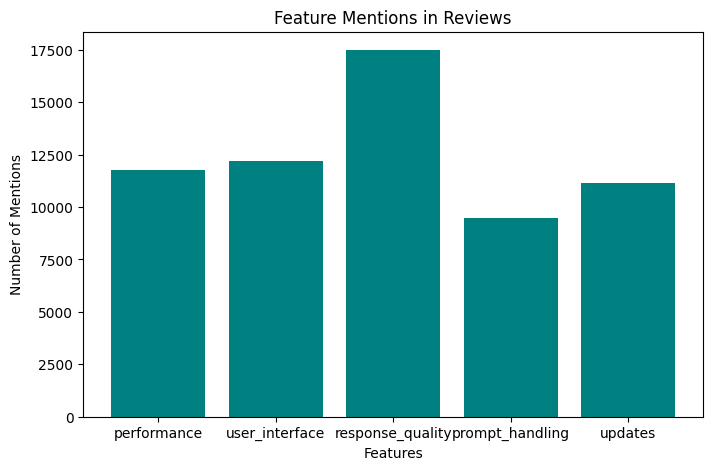

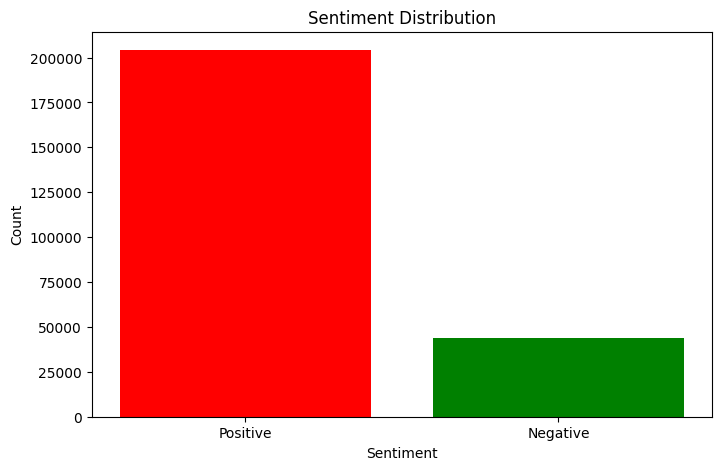

Feature Mention Counts:
{'performance': 11749, 'user_interface': 12189, 'response_quality': 17491, 'prompt_handling': 9458, 'updates': 11152}

Sentiment Distribution:
Sentiment
Positive    204162
Negative     43992
Name: count, dtype: int64


In [11]:
# Plot feature mentions
plt.figure(figsize=(8, 5))
plt.bar(feature_counts.keys(), feature_counts.values(), color='teal')
plt.title('Feature Mentions in Reviews')
plt.xlabel('Features')
plt.ylabel('Number of Mentions')
plt.show()

# Plot sentiment distribution
colors = ['#FF0000', '#008000']
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


# Output feature and sentiment insights
print("Feature Mention Counts:")
print(feature_counts)

print("\nSentiment Distribution:")
print(sentiment_counts)


In [12]:
# Aggregate feature mentions and sentiments
feature_counts = {feature: df[feature].sum() for feature in features}
sentiment_counts = df['Sentiment'].value_counts()

In [13]:
for feature in features:
    print(f"{feature}: {df[feature].sum()}")


performance: 11749
user_interface: 12189
response_quality: 17491
prompt_handling: 9458
updates: 11152


Feature-Specific Sentiment Counts:
Performance: {'Positive': 8728, 'Negative': 3021}
User_interface: {'Positive': 9715, 'Negative': 2474}
Response_quality: {'Positive': 12967, 'Negative': 4524}
Prompt_handling: {'Positive': 7307, 'Negative': 2151}
Updates: {'Positive': 7263, 'Negative': 3889}


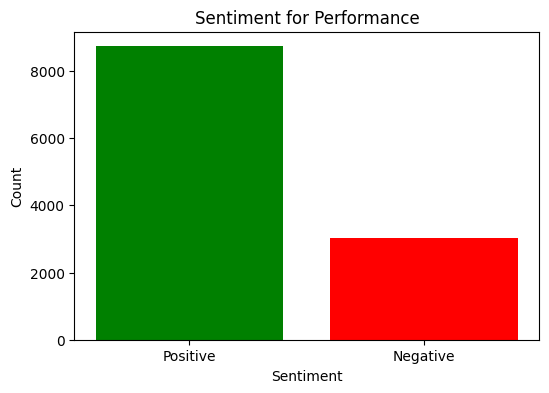

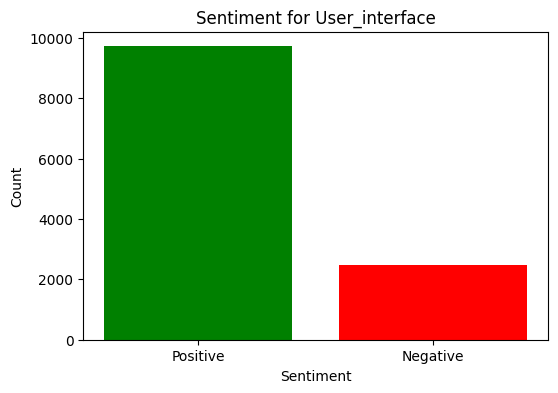

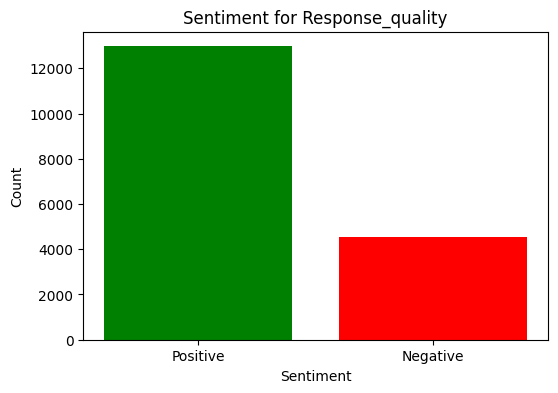

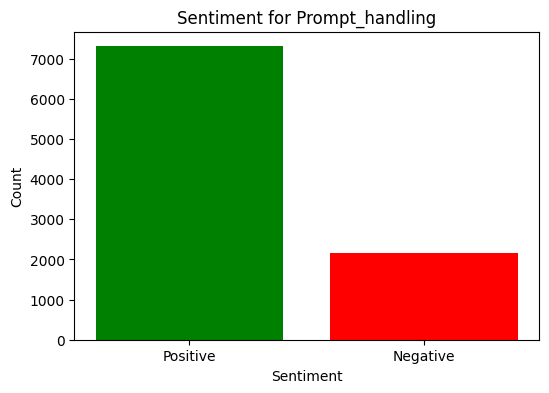

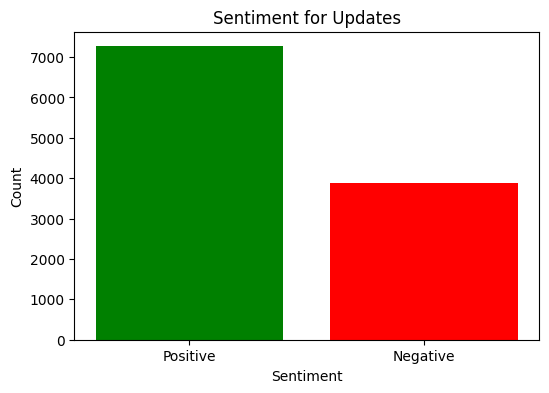

In [14]:
# Count positive and negative reviews for each feature
feature_sentiment_counts = {}
for feature in features:
    positive_count = len(df[(df[feature] == 1) & (df['Sentiment'] == 'Positive')])
    negative_count = len(df[(df[feature] == 1) & (df['Sentiment'] == 'Negative')])
    feature_sentiment_counts[feature] = {'Positive': positive_count, 'Negative': negative_count}

# Display feature sentiment counts
print("Feature-Specific Sentiment Counts:")
for feature, counts in feature_sentiment_counts.items():
    print(f"{feature.capitalize()}: {counts}")

# Optional: Plot feature sentiment counts
for feature, counts in feature_sentiment_counts.items():
    plt.figure(figsize=(6, 4))
    plt.bar(counts.keys(), counts.values(), color=['green', 'red'])
    plt.title(f'Sentiment for {feature.capitalize()}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

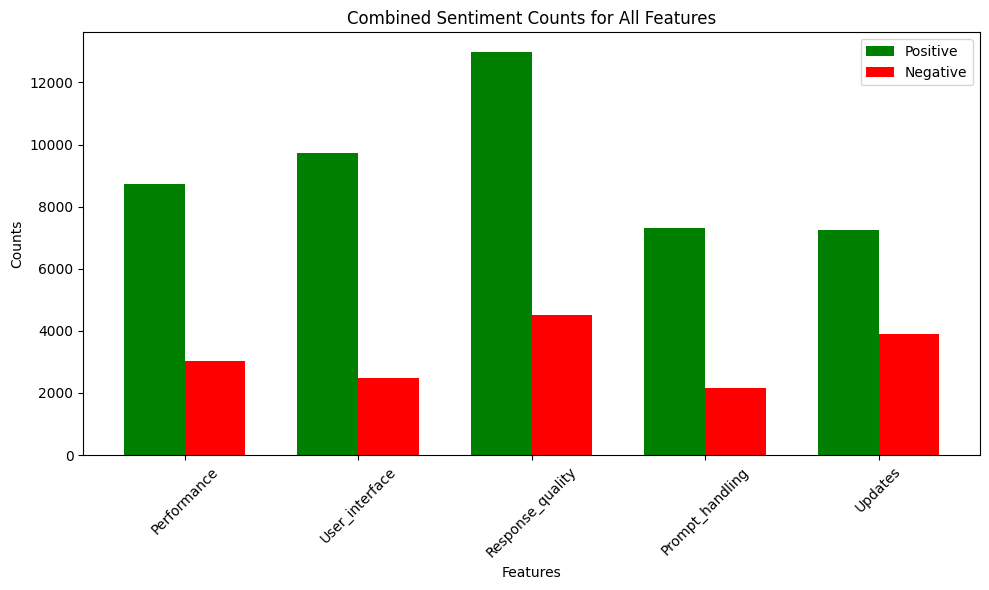

In [15]:
# Prepare data for the combined graph
features = list(feature_sentiment_counts.keys())  # Feature names
positive_counts = [counts['Positive'] for counts in feature_sentiment_counts.values()]
negative_counts = [counts['Negative'] for counts in feature_sentiment_counts.values()]

# Create positions for bars
x = np.arange(len(features))  # X-axis positions for features
width = 0.35  # Width of each bar

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, positive_counts, width, label='Positive', color='green')
plt.bar(x + width/2, negative_counts, width, label='Negative', color='red')

# Add labels, title, and legend
plt.xlabel('Features')
plt.ylabel('Counts')
plt.title('Combined Sentiment Counts for All Features')
plt.xticks(x, [feature.capitalize() for feature in features], rotation=45)  # Rotate feature names for readability
plt.legend()

# Show the combined plot
plt.tight_layout()
plt.show()

In [16]:
print(type(features))


<class 'list'>


In [17]:
features = {
    'performance': ['performance','accurate', 'faster', 'freeze', 'slow', 'crash','loading','delay','smooth','easy','speed','responsive','lag','frozen','hang','buffering','glitch'],
    'user_interface': ['ui','notifaction','alert', 'voice','dicpate','recording','recognition','user interface','responsive','drop down','customize','style','ux','interface', 'intuitive', 'design','friendly', 'navigation','buttons','button','menu','icons','theme','visual','look','feel','front','dark mode'],
    'response_quality': ['correct', 'response', 'language', 'accuracy', 'answer','output','insightful','incorrect','irrelevant','misleading','ambiguous','inaccurate','vague','informative','detailed','understandable','understand'],
    'prompt_handling': ['prompt', 'question', 'input', 'command','generate','clarify','interpret','execution','instruction','query','prompt engineering','misinterpret','retry','feedback','understands'],
    'updates': [' fix', 'update', 'updates','updated','bug', 'error','improvement','beta','agreed','improved','version','modify','modified','resolve','resolved','outdated','patch','support','issues']
}


In [18]:
for feature in features.keys():
    if feature in df.columns:
        print(f"Sample data for '{feature}':")
        print(df[feature].head())
        print()
    else:
        print(f"Feature '{feature}' not found in DataFrame.")

for feature in features.keys():
    null_count = df[feature].isnull().sum()
    empty_strings = (df[feature] == '').sum()
    print(f"Null values in '{feature}': {null_count}")
    print(f"Empty strings in '{feature}': {empty_strings}")


Sample data for 'performance':
0    False
1    False
2    False
3    False
4    False
Name: performance, dtype: bool

Sample data for 'user_interface':
0    False
1    False
2    False
3    False
4    False
Name: user_interface, dtype: bool

Sample data for 'response_quality':
0    False
1    False
2    False
3    False
4    False
Name: response_quality, dtype: bool

Sample data for 'prompt_handling':
0    False
1    False
2    False
3    False
4    False
Name: prompt_handling, dtype: bool

Sample data for 'updates':
0    False
1    False
2    False
3    False
4    False
Name: updates, dtype: bool

Null values in 'performance': 0
Empty strings in 'performance': 0
Null values in 'user_interface': 0
Empty strings in 'user_interface': 0
Null values in 'response_quality': 0
Empty strings in 'response_quality': 0
Null values in 'prompt_handling': 0
Empty strings in 'prompt_handling': 0
Null values in 'updates': 0
Empty strings in 'updates': 0


In [19]:
for feature, keywords in features.items():
    print(f"Keywords for '{feature}': {keywords}")
for feature in features:
    features[feature] = [keyword.strip().lower() for keyword in features[feature]]


Keywords for 'performance': ['performance', 'accurate', 'faster', 'freeze', 'slow', 'crash', 'loading', 'delay', 'smooth', 'easy', 'speed', 'responsive', 'lag', 'frozen', 'hang', 'buffering', 'glitch']
Keywords for 'user_interface': ['ui', 'notifaction', 'alert', 'voice', 'dicpate', 'recording', 'recognition', 'user interface', 'responsive', 'drop down', 'customize', 'style', 'ux', 'interface', 'intuitive', 'design', 'friendly', 'navigation', 'buttons', 'button', 'menu', 'icons', 'theme', 'visual', 'look', 'feel', 'front', 'dark mode']
Keywords for 'response_quality': ['correct', 'response', 'language', 'accuracy', 'answer', 'output', 'insightful', 'incorrect', 'irrelevant', 'misleading', 'ambiguous', 'inaccurate', 'vague', 'informative', 'detailed', 'understandable', 'understand']
Keywords for 'prompt_handling': ['prompt', 'question', 'input', 'command', 'generate', 'clarify', 'interpret', 'execution', 'instruction', 'query', 'prompt engineering', 'misinterpret', 'retry', 'feedback', 

In [20]:
# Replace 'comments' with the actual name of your text data column
text_column = 'cleaned_tokens'



In [21]:
# Print all column names in the DataFrame
print("Columns in the DataFrame:")
print(df.columns.tolist())


Columns in the DataFrame:
['reviewId', 'userName', 'Review', 'score', 'date_time', 'appVersion', 'date', 'time', 'Score_Sentiment', 'tokens', 'cleaned_tokens', 'Text_Sentiment', 'Emoji_Sentiment', 'Overall_Sentiment', 'performance', 'user_interface', 'response_quality', 'prompt_handling', 'updates', 'Sentiment']


In [22]:
def get_top_words(text_data, keywords):
    """
    Extracts the top words or phrases related to given keywords from text data.
    """
    # Combine all text, convert to lowercase, and clean punctuation
    combined_text = ' '.join(text_data.astype(str)).lower()
    import re
    combined_text = re.sub(r'[^\w\s]', '', combined_text)  # Remove punctuation
    
    from collections import Counter
    keyword_counts = Counter()
    
    for keyword in keywords:
        # Use re.escape to handle any special characters in keyword
        pattern = r'\b' + re.escape(keyword.lower()) + r'\b'
        matches = re.findall(pattern, combined_text)
        count = len(matches)
        if count > 0:
            keyword_counts[keyword] = count
    
    return sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)


In [23]:
top_words_per_feature = {}

for feature, keywords in features.items():
    if feature in df.columns:
        # Filter the DataFrame where the feature flag is True
        df_filtered = df[df[feature] == True]
        
        # Check if there is any data after filtering
        if not df_filtered.empty:
            # Pass the text data from the text column to the function
            top_words_per_feature[feature] = get_top_words(df_filtered[text_column], keywords)
        else:
            print(f"No entries found for feature '{feature}'.")
            top_words_per_feature[feature] = []
    else:
        print(f"Feature column '{feature}' not found in DataFrame.")
        top_words_per_feature[feature] = []


In [24]:
# Display the results
for feature, top_words in top_words_per_feature.items():
    print(f"Top words for {feature.capitalize()}:")
    if top_words:
        for word, count in top_words:
            print(f"  {word}: {count}")
    else:
        print("  No keywords found.")
    print()


Top words for Performance:
  easy: 3748
  accurate: 1951
  performance: 656
  slow: 568
  faster: 422
  smooth: 313
  loading: 278
  crash: 269
  glitch: 252
  speed: 240
  responsive: 228
  lag: 154
  hang: 69
  freeze: 59
  delay: 53
  buffering: 15
  frozen: 3

Top words for User_interface:
  voice: 3642
  feel: 1288
  friendly: 805
  interface: 788
  look: 541
  button: 430
  ui: 403
  intuitive: 305
  responsive: 228
  design: 224
  user interface: 133
  style: 118
  recognition: 116
  theme: 91
  menu: 86
  recording: 61
  visual: 57
  dark mode: 49
  ux: 44
  front: 42
  navigation: 41
  customize: 21
  alert: 13

Top words for Response_quality:
  answer: 9917
  response: 3615
  language: 2167
  understand: 1627
  correct: 1069
  informative: 761
  detailed: 331
  accuracy: 318
  insightful: 270
  output: 224
  incorrect: 189
  inaccurate: 174
  understandable: 103
  irrelevant: 37
  misleading: 22
  vague: 22
  ambiguous: 5

Top words for Prompt_handling:
  question: 6983
  gen

In [25]:
# nltk.download('stopwords')
text_data = ' '.join(df['Review'].astype(str))
text_data = text_data.lower()
text_data = re.sub(r'[^a-z\s]', '', text_data)
words = text_data.split()
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]
word_count = Counter(filtered_words)

most_common_words = word_count.most_common(10)
for word, freq in most_common_words:
    print(f'{word}: {freq}')

app: 67945
good: 56922
best: 24261
nice: 20053
helpful: 15986
great: 15778
ai: 13525
chatgpt: 12367
like: 11765
amazing: 11452
